## Dataset and DataLoader with MNIST data

MNIST 는 gray image 이기 때문에 image 로 볼 수 있습니다. matplotlib 을 이용한 이미지 출력 함수 `imshow` 를 만듭니다.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    """
    Notes
    -----
    plt.imshow input : numpy.ndarray
        Shape:
            (M, N) : 1 channel image
            (M, N, 3) : RBG channel image
            (M, N, 4) : RBGA channel image
    """
    npimg = img.squeeze().numpy() # (1, 28, 28) -> (28, 28)
    plt.imshow(npimg, cmap='gray')
    plt.show()

torchvision 에서 datasets 을 import 합니다. `torch_data_dir` 은 fetch 받은 데이터들의 저장 위치입니다.

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchvision import datasets, transforms

from config import torch_data_dir

print(torch.__version__)

1.0.1.post2


dataset 에서 MNIST 를 불러옵니다. `download=True` 로 설정하면 `torch_data_dir` 에 데이터가 없을 경우 다운로드 받습니다. transform 은 파일을 읽어 torch.Tensor 형태로 변형하는 함수 입니다.

In [3]:
transform_func = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = datasets.MNIST(
    torch_data_dir, train=True, download=True,
    transform=transform_func)

test_dataset = datasets.MNIST(
    torch_data_dir, train=False, download=True,
    transform=transform_func)

Dataset 은 `__len__` 과 `__getitem__` 이 구현되어 있습니다. `__len__` 에 의하여 데이터셋의 길이를 확인할 수 있습니다.

In [4]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


`__getitem__` 에 의하여 특정 데이터를 가져올 수 있습니다. MNIST data 는 (28, 28) 의 image 입니다.

torch.Size([1, 28, 28])
tensor(2)


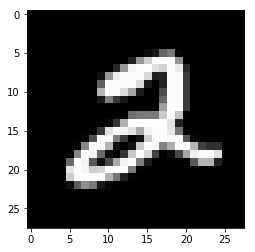

In [5]:
X, y = train_dataset[5]
print(X.size())
print(y)

imshow(X)    

Index 가 넘어가면 IndexError 가 출력됩니다.

In [6]:
train_dataset[60000]

IndexError: index 60000 is out of bounds for dimension 0 with size 60000

MNIST dataset 은 모든 데이터를 memory 에 올려둔 형태입니다. 만약 데이터의 크기가 매우 크다면 이 부분을 Gensim Word2Vec 의 input 처럼 index 가 입력된 부분만 읽는 형식으로 만들 수도 있습니다.

In [7]:
print(train_dataset.train_data.size())
print(train_dataset.train_labels.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


DataLoader 는 dataset 의 데이터를 shuffle 할 수도 있으며, mini batch 로 yield 합니다. 또한 torch 내부에서 데이터를 읽어들이는 부분과 모델을 학습하는 부분을 병렬로 처리할 수 있도록 도와줍니다.

train_loader 의 mini batch size 는 64 이기 때문에 각 batch 별로 (64, 1, 28, 28) 의 tensor (64 장의 images) 가 yield 됩니다.

In [8]:
batch_size = 64
use_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

for i_batch, (X, y) in enumerate(train_loader):
    if i_batch >= 3:
        break
    print('Batch # {}'.format(i_batch))
    print('X: {}, {}'.format(X.size(), type(X)))
    print('y: {}, {}'.format(y.size(), type(y)), end='\n\n')

Batch # 0
X: torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>
y: torch.Size([64]), <class 'torch.Tensor'>

Batch # 1
X: torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>
y: torch.Size([64]), <class 'torch.Tensor'>

Batch # 2
X: torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>
y: torch.Size([64]), <class 'torch.Tensor'>



## Custom Dataset

우리가 이용할 데이터 역시 dataset 으로 만들어 DataLoader 를 이용할 수 있습니다. 토크나이징이 된 네이버 영화평 데이터의 단어를 vocabulary index 로 치환하여 comments images 를 만들었습니다. 데이터의 한 줄은 아래처럼 vocabulary index 가 띄어쓰기로 나뉘어져 있는 형태입니다. 문장마다 길이가 다릅니다.

In [9]:
from navermovie_comments import get_comments_image_path

x_path, y_path, vocab_path = get_comments_image_path(large=False, tokenize='soynlp_unsup')

with open(x_path, encoding='utf-8') as f:
    for _ in range(4):
        print(next(f).strip())

590 699 126 188 205 5 126 13
493 14 757 65 108 1580 590 699 126 272 8965 154 7 851 575 8517 6 620 953 104 24 153
126 1029 263 536 220 245 11327 312 120 8 13 6743 4254
224 497 71 2430 10 10558


CommentsImage 는 위의 데이터를 numpy.ndarray 형태로 읽어들입니다. 문장의 길이가 다르기 때문에 짧은 문장의 경우에는 <padding> 이 추가됩니다. padding index 는 마지막 vocabulary index 입니다..

In [10]:
from navermovie_comments import load_comments_image

X, y, idx_to_vocab = load_comments_image(
    large=False, tokenize='soynlp_unsup', max_len=20)

print(type(X), X.shape)
print(type(y), y.shape)
print(idx_to_vocab[-5:])

<class 'numpy.ndarray'> (294078, 20)
<class 'numpy.ndarray'> (294078,)
['살아남는것', 'Mar', '농업', '대장님', '<padding>']


In [11]:
X[:3]

array([[  590,   699,   126,   188,   205,     5,   126,    13, 26809,
        26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809,
        26809, 26809],
       [  493,    14,   757,    65,   108,  1580,   590,   699,   126,
          272,  8965,   154,     7,   851,   575,  8517,     6,   620,
          953,   104],
       [  126,  1029,   263,   536,   220,   245, 11327,   312,   120,
            8,    13,  6743,  4254, 26809, 26809, 26809, 26809, 26809,
        26809, 26809]])

`__getitem__` 과 `__len__` 을 구현하여 torch 의 Dataset 으로 만듭니다. `init` 부분에서 numpy.ndarray 를 torch.Tensor 로 변환하는 부분을 추가합니다.

In [12]:
from navermovie_comments import load_comments_image

class CommentsImage(torch.utils.data.Dataset):
    def __init__(self, large=False, max_len=20):
        super(CommentsImage, self).__init__()
        # use only this tokenizer
        tokenize = 'soynlp_unsup'

        self.X, labels, self.idx_to_vocab = load_comments_image(
            large=large, tokenize=tokenize, max_len=max_len)

        # {0: negative, 1: neutral, 2: positive}
        labels[np.where(labels < 4)[0]] = 0
        labels[np.where((labels >= 4) & (labels < 8))] = 1
        labels[np.where(8 <= labels)[0]] = 2
        self.labels = labels

        # transform numpy.ndarray to torch.tensor
        self.X = torch.LongTensor(self.X)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.labels[index]
        return X, y

comments_images = CommentsImage()

print(len(comments_images))

X, y = comments_images[3]
print(X)
print(y)

294078
tensor([  224,   497,    71,  2430,    10, 10558, 26809, 26809, 26809, 26809,
        26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809])
tensor(2)


comments_images 를 DataLoader 에 입력할 수 있습니다.

In [14]:
comments_loader = torch.utils.data.DataLoader(
    comments_images, batch_size=4, shuffle=False)

for X, y in comments_loader:
    print(X)
    print(y)
    print(X.size())
    break

tensor([[  590,   699,   126,   188,   205,     5,   126,    13, 26809, 26809,
         26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809],
        [  493,    14,   757,    65,   108,  1580,   590,   699,   126,   272,
          8965,   154,     7,   851,   575,  8517,     6,   620,   953,   104],
        [  126,  1029,   263,   536,   220,   245, 11327,   312,   120,     8,
            13,  6743,  4254, 26809, 26809, 26809, 26809, 26809, 26809, 26809],
        [  224,   497,    71,  2430,    10, 10558, 26809, 26809, 26809, 26809,
         26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809, 26809]])
tensor([2, 2, 2, 2])
torch.Size([4, 20])


## Dataset for large size

만약 이미지 파일처럼 각각의 instance 가 파일로 나뉘어져 있을 경우에는 index 별 file path 를 저장한 뒤, getitem 에서 각 파일을 loading 하는 함수로 만들 수 있습니다.

In [15]:
class MemoryFriendlyDataset(torch.utils.data.Dataset):
    def __init__(self, index_to_file):
        super(MemoryFriendlyDataset, self).__init__()
        self.index_to_file = index_to_file

    def __len__(self):
        return len(self.index_to_file)

    def __getitem__(self, index):
        path = self.index_to_file[index]
        X, y = self._load_instance(path)

    def _load_instance(self, path):
        raise NotImplemented

DataLoader 에 대한 설명은 다음의 포스트를 참고하세요.

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel